# Explore the composition of Illumina RNA seq data sets in the Sequence Read Archive

In [21]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)

In [1]:
setwd("..")

In [4]:
library(dplyr)
library(janitor)
library(purrr)
library(readr)
library(ggplot2)
library(tidyr)

## Download and read metadata files

In [6]:
# download metadata files
destfile <- "inputs/gtdb-rs207/bac120_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-rs207/bac120_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

destfile <- "inputs/gtdb-rs207/ar53_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/ar53_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-r207/ar53_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

In [8]:
# combine bacterial and archaeal metadata
gtdb_metadata <- read_tsv("inputs/gtdb-rs207/bac120_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("superkingdom", "phylum", "class", "order", "family", "genus", "species"), sep = ";") %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb-rs207/ar53_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("superkingdom", "phylum", "class", "order", "family", "genus", "species"), sep = ";") %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession)) %>%
  bind_rows(gtdb_metadata)

Warning message:
“One or more parsing issues, see `problems()` for details”


In [11]:
ena <- read_tsv("inputs/20220407_runinfo.tsv.gz", show_col_types = F)

## Descriptive stats & numbers for SRA

In [12]:
# how many total RNA seq experiments are there?
nrow(ena)

[1] 59239

In [13]:
# how many distinct species are there (using NCBI taxonomy)?
length(unique(ena$scientific_name)) 

[1] 1681

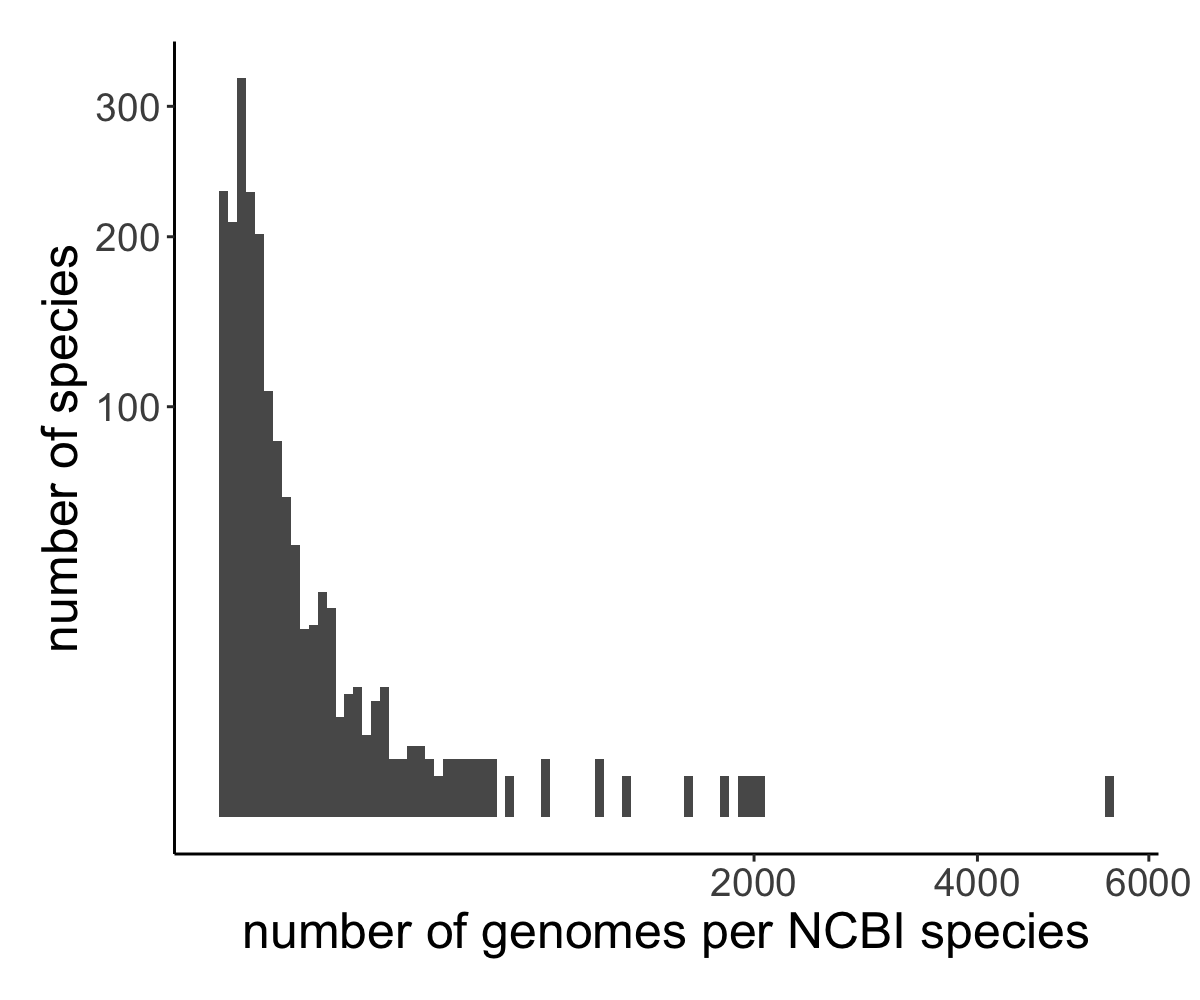

In [52]:
# what is the distribution of the number of data sets per species?
ena_org_tally <- ena %>% group_by(scientific_name) %>% tally()
ggplot(ena_org_tally, aes(x = n)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_sqrt() +
  scale_x_sqrt() +
  labs(x = "number of genomes per NCBI species", y = "number of species") +
  theme(axis.text = element_text(size = 14),
        axis.title= element_text(size = 18), 
        plot.margin = margin(15, 15, 15, 15),
        panel.background = element_rect(fill='transparent'), 
        plot.background = element_rect(fill='transparent', color=NA))

In [31]:
# what is the average read length
mean(ena$base_count/ena$read_count, na.rm = T)
ena <- ena %>%
  mutate(mean_read_length = base_count/read_count)

[1] 150.383

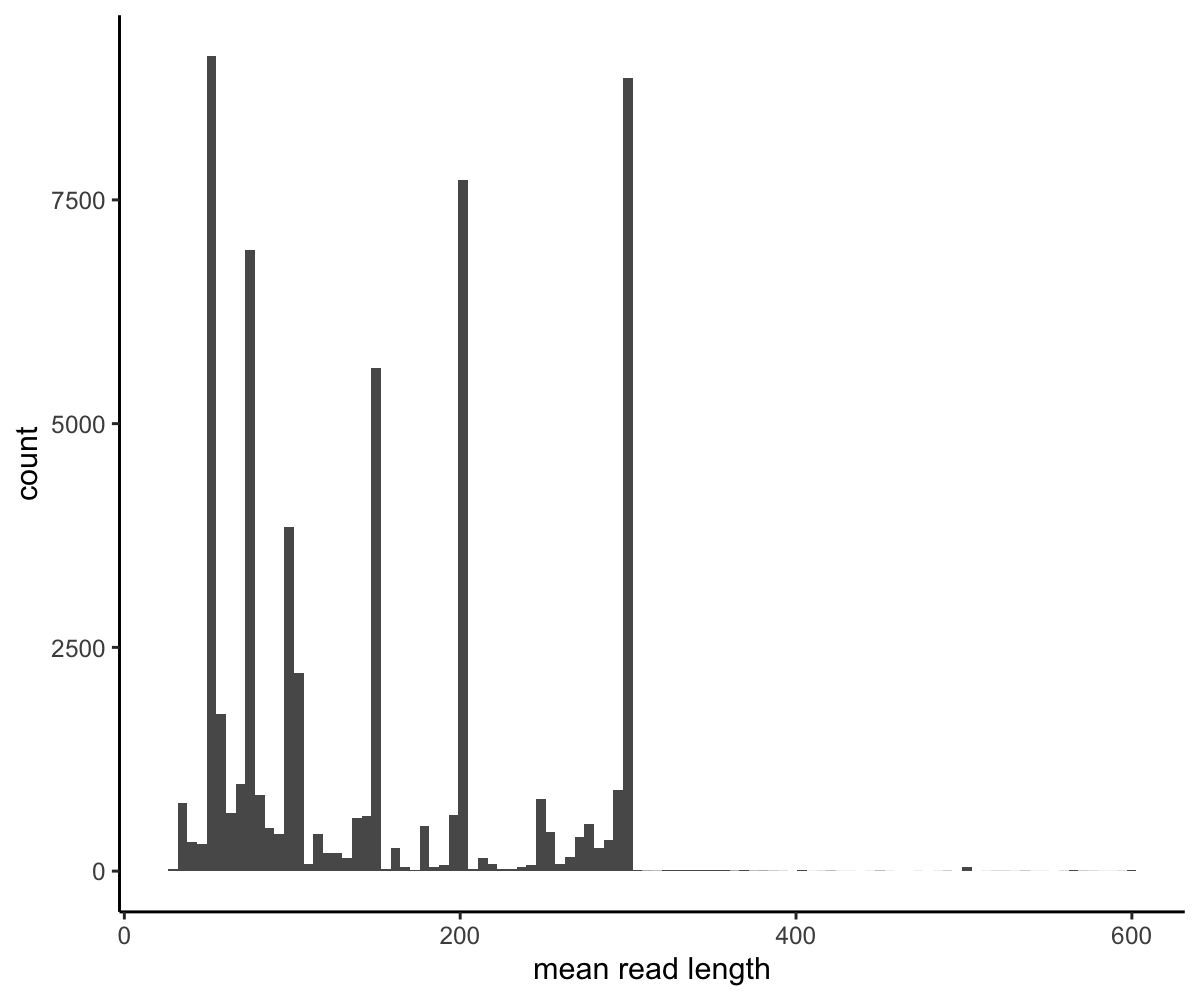

In [36]:
ggplot(ena, aes(x = mean_read_length))  +
  geom_histogram(bins = 100) +
  theme_classic() +
  labs(x = "mean read length")


In [37]:
table(ena$mean_read_length < 31)


FALSE 
59239 

## Descriptive stats & numbers for GTDB

In [39]:
# make gtdb to ncbi map
gtdb_to_ncbi_map <- gtdb_metadata %>%
  select(ncbi_organism_name, superkingdom, phylum, class, order, family, genus, species) %>%
  distinct()
  
# create map of GTDB to NCBI 
ena_to_gtdb_map <- ena %>%
  select(scientific_name) %>%
  distinct() %>%
  left_join(gtdb_to_ncbi_map, by = c("scientific_name" = "ncbi_organism_name"))

In [42]:
# how many data sets don't have a representative genome within the GTDB taxonomy,
# using only GTDB <-> SRA taxonomy map (as opposed to using sourmash gather to
# infer the species). Note species map fails when species is labelled wrong, which
# happens at least sometimes (determined by eye).

ena_with_gtdb <- ena %>%
  left_join(ena_to_gtdb_map)

ena_no_gtdb_species <- ena_with_gtdb[is.na(ena_with_gtdb$species), ]
nrow(ena_no_gtdb_species) # 2,458 samples don't have a species by text-based analysis

Joining, by = "scientific_name"


[1] 2458

In [43]:
length(unique(ena_no_gtdb_species$scientific_name)) # 281 species don't have species-level ref genomes in GTDB by text-based analysis

[1] 281

In [44]:
# printed the NCBI species names that weren't in GTDB. Most of these are either:
# + labelled at the genus level
# + contain a strain name that prevents exact matching of names
# So these likely do have species representatives in GTDB, and gather will be able to pull them out.
unique(ena_no_gtdb_species$scientific_name)

[1] "Pseudomonas ogarae"                                                     
  [2] "Marinobacter nauticus"                                                  
  [3] "Dinoroseobacter shibae"                                                 
  [4] "Synechocystis"                                                          
  [5] "Streptomyces"                                                           
  [6] "Enterococcus"                                                           
  [7] "Deinococcus"                                                            
  [8] "Pseudomonas"                                                            
  [9] "Methylovirgula sp. HY1"                                                 
 [10] "Acinetobacter"                                                          
 [11] "prokaryote coculture"                                                   
 [12] "Microcystis sp. FACHB-905"                                              
 [13] "Synechococcus sp. CCMP2370"                                             
 [14] "Endozoicomonas sp. 6c"                                                  
 [15] "Lacticaseibacillus rhamnosus GG"                                        
 [16] "Escherichia"                                                            
 [17] "Pseudomonas sp. L5B5"                                                   
 [18] "Streptomyces bingchenggensis"                                           
 [19] "Cylindrospermopsis raciborskii FACHB-1096"                              
 [20] "Paenibacillus sp. 59PA"                                                 
 [21] "Ligilactobacillus faecis"                                               
 [22] "metagenome"                                                             
 [23] "Chenggangzhangella methanolivorans"                                     
 [24] "Caenibius sp. WL"                                                       
 [25] "Victivallaceae bacterium zth2"                                          
 [26] "Amycolatopsis"                                                          
 [27] "Colwellia sp. M166"                                                     
 [28] "Roseovarius sp. M141"                                                   
 [29] "bacterial mixed RNA library"                                            
 [30] "Pandoraea sp. Col-0-28"                                                 
 [31] "Cereibacter sphaeroides 2.4.1"                                          
 [32] "Nostoc punctiforme Reg"                                                 
 [33] "Nostoc punctiforme RR"                                                  
 [34] "Nostoc punctiforme UCD 153"                                             
 [35] "Bacillus atrophaeus ATCC 9372"                                          
 [36] "Priestia megaterium QM B1551"                                           
 [37] "Salmonella enterica subsp. enterica serovar Typhimurium str. ATCC 14028"
 [38] "Dactylosporangium vinaceum"                                             
 [39] "Synechococcus"                                                          
 [40] "Helicobacter pylori NCTC 11637 = CCUG 17874 = ATCC 43504 = JCM 12093"   
 [41] "mixed culture bacterium"                                                
 [42] "Dehalococcoides"                                                        
 [43] "uncultured marine bacterium"                                            
 [44] "Levilactobacillus brevis ATCC 367"                                      
 [45] "Cronobacter"                                                            
 [46] "Methylocystis"                                                          
 [47] "Gluconobacter oxydans WSH-003"                                          
 [48] "Microcystis aeruginosa PCC 7806"                                        
 [49] "Pseudoalteromonas sp. CF6-2"                                            
 [50] "Lactiplantibacillus plantarum ST-III"                                   
 [

In [45]:
## how many distinct species are there (using GTDB taxonomy)?
ena_with_gtdb_has_species <- ena_with_gtdb[!is.na(ena_with_gtdb$species), ]
length(unique(ena_with_gtdb_has_species$scientific_name)) # 1,400 in NCBI taxonomy
length(unique(ena_with_gtdb_has_species$species)) # 3,142 in GTDB taxonomy with text-based analysis

[1] 1400

[1] 3142

In [46]:
ena_with_gtdb_has_species_tally <- ena_with_gtdb_has_species %>%
  group_by(species) %>%
  tally()
mean(ena_with_gtdb_has_species_tally$n)

[1] 97.7352

In [49]:
# how many species are bacteria? archaea?
 
ena_with_gtdb_has_species_slice <- ena_with_gtdb_has_species %>%
  group_by(experiment_accession) %>%
  slice(1) # only count each experiment onces
table(ena_with_gtdb_has_species_slice$superkingdom)  # d__Archaea 1007 d__Bacteria 50679


 d__Archaea d__Bacteria 
       1007       50679 

## Selecting suitable test species

In [50]:
# pick a second organism to work with whose pangenome isn't quite as large as Pseudomonas a.

gtdb_num_species <- gtdb_metadata %>%
  select(species) %>%
  group_by(species) %>%
  tally() %>%
  select(species, num_genomes_in_gtdb = n)

tmp <- ena_with_gtdb_has_species_tally %>%
  left_join(gtdb_num_species, by = "species")

tmp %>%
       filter(n > 20, num_genomes_in_gtdb > 20) %>%
       filter(n < 80, num_genomes_in_gtdb < 100)

species,n,num_genomes_in_gtdb
<chr>,<int>,<int>
s__Achromobacter xylosoxidans,52,75
s__Aeromonas dhakensis,28,55
s__Agrobacterium deltaense,78,64
s__Agrobacterium pusense,78,79
s__Akkermansia muciniphila_B,27,44
s__Alistipes onderdonkii,36,44
s__Bacillus safensis,31,99
s__Bradyrhizobium diazoefficiens,51,23
s__Bradyrhizobium japonicum,24,22
